In [ ]:
#  dataset EMOUERJ
!gdown 16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW

Downloading...
From (original): https://drive.google.com/uc?id=16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW
From (redirected): https://drive.google.com/uc?id=16MMIiaSZeozAFI7MEBU-eHY0-h7kTXpW&confirm=t&uuid=6248dc76-b47b-47e9-a22c-bb71b64d4927
To: /content/emoUERJ.zip
100% 105M/105M [00:04<00:00, 24.4MB/s]


In [ ]:
pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import librosa
from speechbrain.inference.interfaces import foreign_class
import logging

In [ ]:
classifier = foreign_class(source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP",
                           pymodule_file="custom_interface.py",
                           classname="CustomEncoderWav2vec2Classifier")

iemocap_to_emouerj = {
    'ang': 'angry',
    'hap': 'happy',
    'sad': 'sad',
    'neu': 'neutral',
    'exc': 'happy',
    'fru': 'angry',
}


In [ ]:
# extrair o dataset EMOUERJ
zip_path = 'emoUERJ.zip'
extract_to = 'emoUERJ'
if not os.path.exists(extract_to):
    os.makedirs(extract_to)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# preparar o dataset
audio_dir = os.path.join(extract_to, 'emoUERJ')
data = []
emotion_mapping = {'h': 'happy', 'a': 'angry', 's': 'sad', 'n': 'neutral'}
for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        label_key = filename[3]
        emotion = emotion_mapping.get(label_key, None)
        if emotion:
            data.append({'file': os.path.join(audio_dir, filename), 'emotion': emotion})

df_emoUERJ = pd.DataFrame(data)

In [ ]:
y_true = []
y_pred = []

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
def infer(audio_path):
    try:
        out_prob, score, index, text_lab = classifier.classify_file(audio_path)

        logger.info(f"Raw classification result for {audio_path}: {text_lab}")

        if isinstance(text_lab, list):
            text_lab = text_lab[0]

        text_lab = text_lab.lower()

        predicted_emotion = iemocap_to_emouerj.get(text_lab, 'neutral')
        logger.info(f"Mapped emotion for {audio_path}: {predicted_emotion}")

        return predicted_emotion
    except Exception as e:
        logger.error(f"Error processing {audio_path}: {str(e)}")
        return 'neutral'

In [ ]:
for _, row in tqdm(df_emoUERJ.iterrows(), total=df_emoUERJ.shape[0]):
    audio_path = row['file']
    true_emotion = row['emotion']
    predicted_emotion = infer(audio_path)

    y_true.append(true_emotion)
    y_pred.append(predicted_emotion)

    logger.info(f"File: {audio_path}, True: {true_emotion}, Predicted: {predicted_emotion}")

100%|██████████| 377/377 [03:52<00:00,  1.62it/s]


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

       happy       0.59      0.88      0.71        94
       angry       0.32      0.59      0.41        91
         sad       0.60      0.42      0.50        92
     neutral       1.00      0.02      0.04       100

    accuracy                           0.47       377
   macro avg       0.63      0.48      0.41       377
weighted avg       0.64      0.47      0.41       377

F1 Score: 0.4084


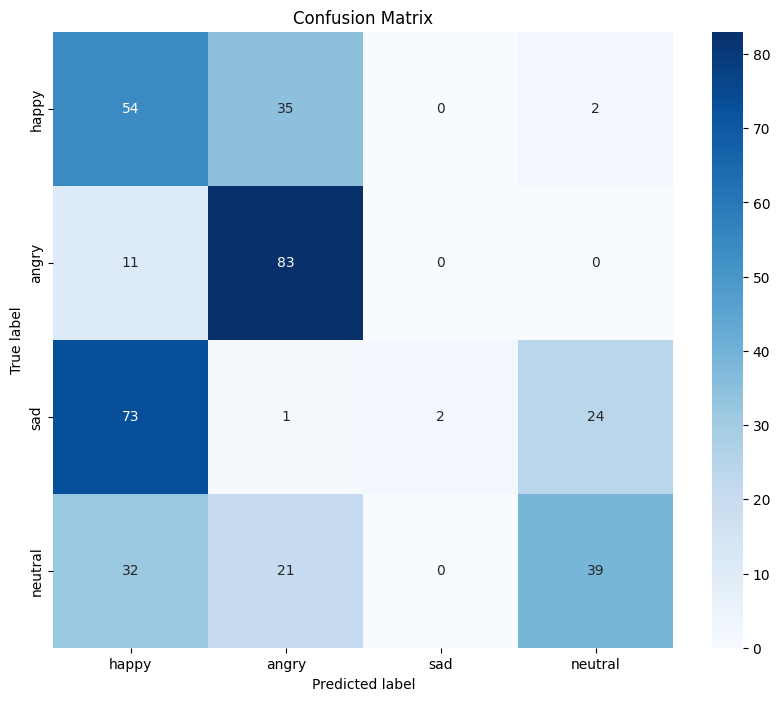

In [ ]:
emouerj_emotions = ['happy', 'angry', 'sad', 'neutral']
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emouerj_emotions))

f1 = f1_score(y_true, y_pred, average='weighted', labels=emouerj_emotions)
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred, labels=emouerj_emotions)
plot_confusion_matrix(cm, classes=emouerj_emotions)